# Polarimeter

## Introduction

A polarimeter is a device to determine de polarization state of a sample. The main components of a polarimeter are: 
* Light Source
* Polarization states generator
* Sample to measure
* Polarization states analyzer
* Detection system

The States generator is formed by a linear polarizer and a $\lambda$/2 waveplate in order to generate any desired state.

The States analyzer is also formed by a linear polarizer and a $\lambda$/2 waveplate, but in reverse order.

The polarimetric properties of the sample, polarizers of the generator and analyzer moves in order to determine the polarimetric propierties of the sample, given by its 4x4 Mueller matrix. Also, the 2x2 Jones matrix can be determine, although not complete information is obtained.

In is example, we will simulate the intensity distribution at the output of an ideal polarimeter given a certain sample. 

## Import required Modules



## Definition of elements

Here we have to create the different elements that define our experiment: the light source, the polarimeter optical elements, and the sample which is going to be measured.

In [2]:
# Define the light source
source = Stokes('s0')
source.circular_light('r')

In [3]:
# Define sample
sample = Mueller('sample')
sample.diattenuator_charac_angles_from_vector(
    p1=.9, p2=.1, alpha=45*degrees, delay=45*degrees)

matrix([[4.10000000e-01, 2.44929360e-17, 2.82842712e-01, 2.82842712e-01],
        [2.44929360e-17, 9.00000000e-02, 1.38552969e-17, 1.38552969e-17],
        [2.82842712e-01, 1.38552969e-17, 2.50000000e-01, 1.60000000e-01],
        [2.82842712e-01, 1.38552969e-17, 1.60000000e-01, 2.50000000e-01]])

In [14]:
# Define polarimeter optical elements
pol_0=Mueller('p0')
pol_0.diattenuator_perfect(angle=0)

pol_1=Mueller('p1')
pol_1.quarter_waveplate(angle=0 * degrees)

pol_2=Mueller('p2')
pol_2.quarter_waveplate(angle=0 * degrees)

pol_3=Mueller('p3')
pol_3.diattenuator_perfect(angle=0)


elements = [pol_0, pol_1, pol_2, pol_3]


## Definition of polarimeter

Here qe are going to create a function that mimics the behavior of the polarimeter experiment. We give it the illumination, the sample, the optical elements of the polarimeter, and a set of rotation angles for those elements. The output of the function will be the intensity corresponding to each set of angles.

In [15]:
def polarimeter(J0, sample, elements, angles_list):
    
    intensities = np.zeros(len(angles_list),float)
    #J1s=[]
    #systems=[]
    
    for i, angles in enumerate(angles_list):

        angle0, angle1, angle2, angle3 = angles

        # Elements matrices
        pol_0 = elements[0].rotate(angle0, keep=False)
        pol_1 = elements[1].rotate(angle1, keep=False)
        pol_2 = elements[2].rotate(angle2, keep=False)
        pol_3 = elements[3].rotate(angle3, keep=False)

        #System matrix
        system = pol_3*pol_2*sample*pol_1*pol_0
        system.name = 'System'
        
        J1 = system*J0

        intensities[i] = J1.parameters.intensity()
        #J1s.append(J1)
        #systems.append(system)
    
    return intensities# , J1s, systems
    

## Example

We are going to test the polarimeter function to see how they work.

### Just 1 position

Here we insert the function just a set of angles, corresponding to 1 measurement.

In [6]:
angles = [0, pi / 4, pi / 4, 0],
intensities = polarimeter(source, sample, elements, angles)
print(intensities)

[0.125]


### Several positions

Now we will make several measurements.

In [7]:
# Define a set of angles
angles_list = [
    [0, pi / 4, pi / 4, 0],
    [0, pi / 4, pi / 4, pi / 4],
    [0, pi / 4, pi / 4, pi / 2],
    [0, pi / 4, pi / 4, pi / 2],
    [pi / 2, pi / 4, pi / 4, pi / 4],
    [pi / 4, pi / 4, pi / 4, pi / 4],
]

In [8]:
# Perform the experiment
intensities = polarimeter(source, sample, elements, angles_list)
print(intensities)

[0.125      0.17321068 0.08       0.08       0.17321068 0.30642136]


### Rotate waveplate of generator

We can investigate how the measured intensity changes as we rotate just one element, for example, a retarder.

In [9]:
# Define a set of angles
angle_0 = 45*degrees
angle_1 = np.linspace(0,360*degrees, 91)
angle_2 = 45*degrees
angle_3 = 0*degrees

angles_list = np.zeros((len(angle_1),4),dtype=float)
angles_list[:,0]=angle_0
angles_list[:,1]=angle_1
angles_list[:,2]=angle_2
angles_list[:,3]=angle_3

angles_list.tolist();

In [10]:
# Perform the experiment
intensities = polarimeter(source, sample, elements, angles_list)

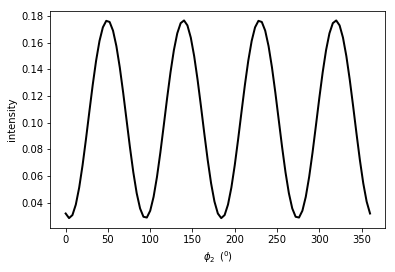

In [11]:
# Plot the result
plt.figure()
plt.plot(angle_1/degrees, intensities,'k', lw=2)
plt.xlabel('$\phi_2\,\ (^0) $')
plt.ylabel('intensity');

## Measure the Mueller matrix

Now, we will see how we can measure the Mueller matrix of the sample. Our case is very simple, as we have a polarimeter with ideal elements and a detector without errors. So, in our case, we only need 16 different measurements in order to determine the Mueller matrix of the sample. 

The procedure to calculate the Mueller matrix of the sample is described in detail in "Handbook of Optics", M. Bass et al., Vol II, Chapter 22 section 18. Now we will implement it.

In [31]:
def calculate_Mueller(illum, elements, angles, intensities):
    
    # Prealocate memory
    system = np.matrix(np.zeros([16,16]))
    
    # Loop along measurements
    for ind in range(16):

        angle0, angle1, angle2, angle3 = angles[ind,:]

        # Elements matrices
        pol_0 = elements[0].rotate(angle0, keep=False)
        pol_1 = elements[1].rotate(angle1, keep=False)
        pol_2 = elements[2].rotate(angle2, keep=False)
        pol_3 = elements[3].rotate(angle3, keep=False)

        # Polarimeter matrices
        generator = pol_1 * pol_0 * illum
        generator.name = 'Generator'
        analyzer = pol_3 * pol_2
        analyzer.name = 'Analyzer'
        
        # System matrix
        a_vector = analyzer.M[0,:]
        g_vector = generator.M
        s_vector = np.kron(a_vector, g_vector.T)
        system[ind,:] = s_vector
        
    # Calculate Mueller matrix
    m_vector = system.I * intensities
    Msample = m_vector.reshape([4,4])
    return Msample

In [32]:
# Create a set of angles for measurements
angles = np.random.rand(16,4)*pi
# Calculate intensities measured by the polarimeter
intensities = polarimeter(source, sample, elements, angles)
intensities = np.matrix(intensities).T
# Calculate the Mueller matrix
Mcalculated = calculate_Mueller(source, elements, angles, intensities)
sampleC = Mueller('Calculated')
sampleC.from_matrix(Mcalculated)
# Print results
print("The Mueller matrix of the sample is:")
print(sample)
print("The calculated Mueller matrix is:")
print(sampleC)

The Mueller matrix of the sample is:
sample = 
  [+0.410, +0.000, +0.283, +0.283]
  [+0.000, +0.090, +0.000, +0.000]
  [+0.283, +0.000, +0.250, +0.160]
  [+0.283, +0.000, +0.160, +0.250]

The calculated Mueller matrix is:
Calculated = 
  [+0.410, +0.000, +0.283, +0.283]
  [+0.000, +0.090, -0.000, +0.000]
  [+0.283, -0.000, +0.250, +0.160]
  [+0.283, -0.000, +0.160, +0.250]

